### Урок 4. Деревья решений

#### __1__. В коде из методички реализуйте один или несколько из критериев останова
(количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [1]:
import numpy as np
import random
from sklearn import datasets
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 4, n_informative = 4, 
                                        n_classes = 2, n_redundant=0, n_clusters_per_class=1, random_state=23)

In [3]:
classification_data[0:10]

array([[-3.21604985, -0.41609911, -1.29514711, -1.88239183],
       [-1.42574548, -1.25705143, -1.73418071, -1.80417395],
       [ 2.79845229, -3.0103545 , -1.08500261, -3.13438413],
       [ 0.63267636,  2.50209792, -1.55265204,  1.62540061],
       [ 1.4939054 ,  0.91199293, -1.88738918, -1.45726171],
       [-0.14381433, -1.03334692, -0.50053326, -0.35086288],
       [ 1.40451014,  0.66874745, -1.46030755, -1.96501857],
       [-4.1986513 , -2.57747185, -1.31446589, -2.76597092],
       [ 0.85091708,  1.28621704, -1.04094969,  0.32513885],
       [ 1.56990877, -0.10970005, -1.95119616, -2.33882683]])

In [4]:
classification_labels

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1])

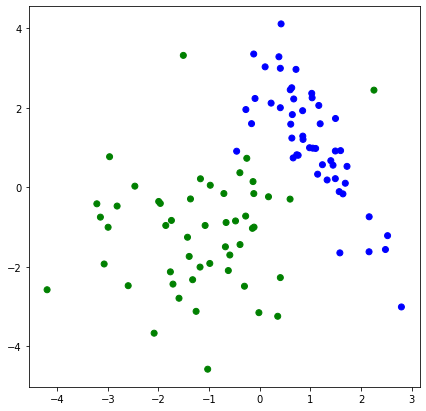

In [5]:
# визуализируем сгенерированные данные
colors = ListedColormap(['green', 'blue'])

plt.figure(figsize=(7,7))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors)

In [6]:
# Реализуем класс узла
class Node:
 
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t          # значение порога
        self.true_branch  = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels              # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [8]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет качества
def quality(left_labels, right_labels, current_gini):
    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    left  = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data  = data[left]
    false_data = data[right]
    true_labels  = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

#### Добавим критерии останова: количество используемых признаков (n_features ) и количество листьев (min_leaf)

In [11]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels, n_features, min_leaf):

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    if n_features > data.shape[1]:  # Не больше имеющихся в наборе данных
        n_features = data.shape[1]  # столбцов-признаков
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, n_features, min_leaf):
    quality, t, index = find_best_split(data, labels, n_features, min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if (quality == 0):
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch  = build_tree(true_data, true_labels, n_features, min_leaf)
    false_branch = build_tree(false_data, false_labels, n_features, min_leaf)
 
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
# Проход объекта по дереву для его классификации
def classify_object(obj, node):
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [14]:
# Предсказание деревом для всего датасета
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [18]:
# Разобьем выборку на обучающую и тестовую
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                    classification_labels, test_size = 0.3, random_state = 1)

In [19]:
# Построим дерево по обучающей выборке и зададим кол-во признаков = 3 и кол-во листьев 4
my_tree = build_tree(train_data, train_labels, n_features=3, min_leaf=4)

In [20]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог',  str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -0.3011223579111354
--> True:
  Прогноз: 0
--> False:
  Индекс 1
  Порог -0.2391707287713687
  --> True:
    Индекс 0
    Порог 0.3556916119374769
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Индекс 0
    Порог 1.4939053991962525
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1


In [21]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
train_answers[0:20]

[0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0]

In [22]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)
answers[:20]

[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]

In [23]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [24]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

97.14285714285714

In [25]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

83.33333333333334

Text(0.5, 1.0, 'Test accuracy=83.33')

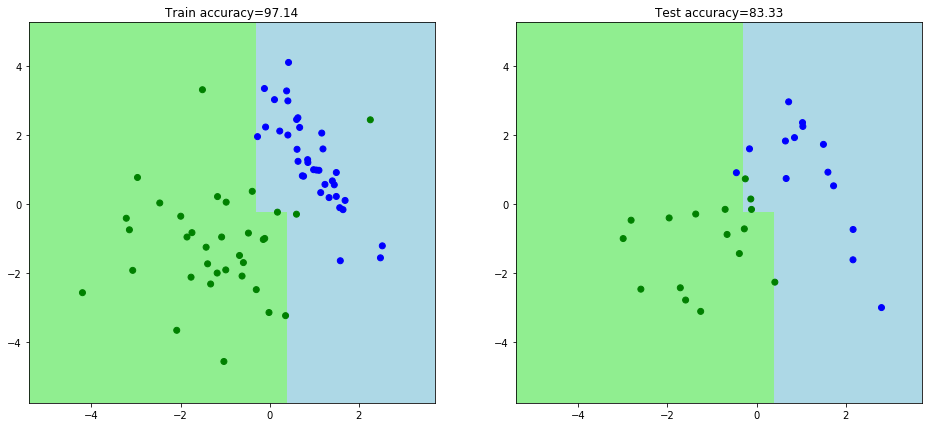

In [26]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
light_colors = ListedColormap(['lightgreen', 'lightblue'])
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [27]:
# Построим дерево по обучающей выборке и зададим кол-во признаков = 4 и кол-во листьев 3
my_tree = build_tree(train_data, train_labels, n_features=4, min_leaf=3)

In [28]:
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)

In [29]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [30]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

86.66666666666667

#### При повышении кол-ва признаков до 4-ч и уменьшения листьев до 3-х, точность прогноза повысилась

Text(0.5, 1.0, 'Test accuracy=86.67')

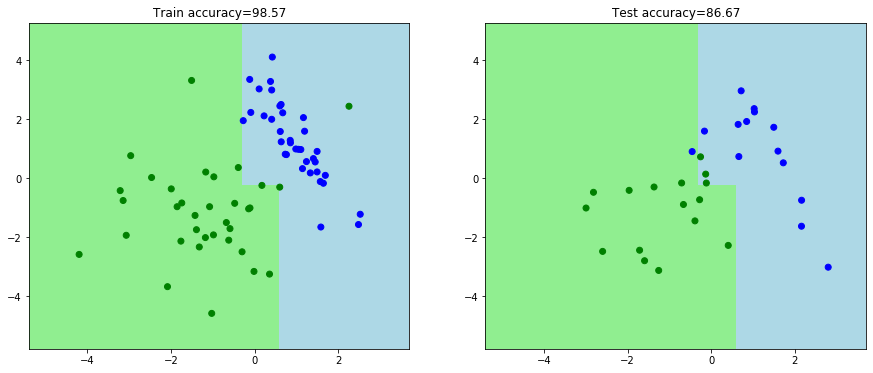

In [31]:
plt.figure(figsize = (15, 6))
# график обучающей выборки
light_colors = ListedColormap(['lightgreen', 'lightblue'])
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

#### __2__. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [32]:
# Реализуем класс узла
class NodeR:
 
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t          # значение порога
        self.true_branch  = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch # поддерево, не удовлетворяющее условию в узле

In [33]:
# И класс терминального узла (листа)
class LeafR:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels              # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        objects = []  # сформируем список объектов в листе
        for label in self.labels:
            objects.append(label)
   
        objects = np.array(objects)
        prediction = objects.mean()
        return prediction

In [34]:
def dispers(values):
    return values.var()

In [35]:
# Расчет качества
def qualityR(left_labels, right_labels, current_disp):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_disp - p * dispers(left_labels) - (1 - p) * dispers(right_labels)

In [36]:
def splitR(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [37]:
# Нахождение наилучшего разбиения
def find_best_splitR(data, labels, n_features, min_leaf):

    current_disp = dispers(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    if n_features > data.shape[1]:  # Не больше имеющихся в наборе данных
        n_features = data.shape[1]  # столбцов-признаков
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        for t in t_values:
            true_data, false_data, true_labels, false_labels = splitR(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = qualityR(true_labels, false_labels, current_disp)
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [38]:
# Построение дерева с помощью рекурсивной функции
def build_treeR(data, labels, n_features, min_leaf):
    quality, t, index = find_best_splitR(data, labels, n_features, min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if (quality == 0):
        return LeafR(data, labels)

    true_data, false_data, true_labels, false_labels = splitR(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch  = build_treeR(true_data, true_labels, n_features, min_leaf)
    false_branch = build_treeR(false_data, false_labels, n_features, min_leaf)
 
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return NodeR(index, t, true_branch, false_branch)

In [39]:
# Проход объекта по дереву для его классификации
def classify_object(obj, node):
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, LeafR):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [40]:
# Предсказание деревом для всего датасета
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [41]:
regress_data, regress_target = datasets.make_regression(n_samples=100, n_features=4, 
                            n_informative=4, n_targets=1, shuffle=True, coef=False, random_state=42)

In [42]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(regress_data, regress_target,
                                                                                    test_size = 0.3, random_state = 42)

In [43]:
my_tree = build_treeR(train_data, train_labels, n_features=4, min_leaf=4)

In [44]:
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)
answers[0:10]

[153.4344325112976,
 -80.03344447349836,
 153.4344325112976,
 23.406547390712483,
 153.4344325112976,
 25.69117447330691,
 15.47271838339494,
 -98.57938725193449,
 -144.86168451636883,
 -80.03344447349836]

In [45]:
from sklearn.metrics import mean_squared_error, r2_score

In [46]:
mean_squared_error(train_labels, train_answers)

612.2190935395314

In [47]:
mean_squared_error(test_labels, answers)

2076.338678016177

In [48]:
r2_score(train_labels, train_answers)

0.9357924146806192

In [49]:
r2_score(test_labels, answers)

0.7338032879084307